In [1]:
import numpy as np
import glob
import xarray as xr
import netCDF4

import matplotlib.pyplot as plt
from matplotlib import rcParams

# CPOL convenience functions
import CPOL_func as cf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func

In [37]:
ref.z[-1]

<xarray.DataArray 'z' ()>
array(20000.)
Coordinates:
    time     datetime64[ns] 2006-02-09T10:20:00
    z        float64 2e+04
Attributes:
    long_name:      Z distance on the projection plane from the origin
    units:          m
    standard_name:  projection_z_coordinate
    axis:           Z
    positive:       up

In [54]:
test = (wrf['PH']+wrf['PHB'])/9.8

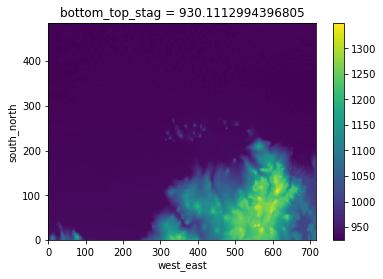

In [82]:
test[0,15,:,:].plot()

In [83]:
ref = xr.open_dataset('/g/data/w40/esh563/lind04/dbz/2006-02-09_10:20:00alllevels_zlib.nc')
ref_t = np.load('/g/data/w40/esh563/thompsond04/dbz/2006-02-09_10:20:00alllevels_zlib.npy')
ref['y'] = ref.longitude[0,0,0,:].squeeze().values
ref['x'] = ref.latitude[0,0,:,0].squeeze().values
ref = ref.rename({'x':'y', 'y':'x'})
ref = ref.isel(time=0)

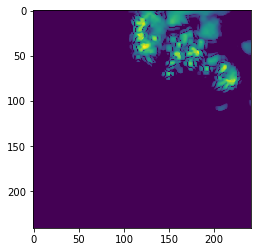

In [87]:
plt.imshow(ref_t[6,:,:])

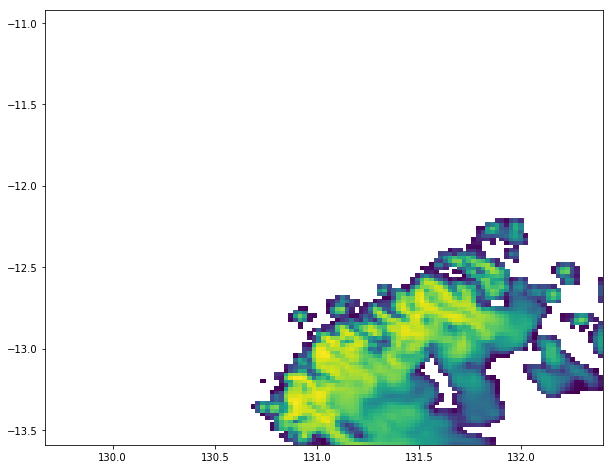

In [88]:
fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(ref.x, ref.y, ref.reflectivity.sel(z=3000))

In [6]:
wrf = xr.open_dataset('/g/data/w40/esh563/d04.dir/wrfout_d04_2006-02-09_10:00:00.nc.gz')
hgt_AGL = np.load('/g/data/w40/esh563/d04_hgt_AGL.npy')
# Create function to de
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

wrf['bottom_top']=moving_average(hgt_AGL, n=2)
wrf['bottom_top_stag'] = hgt_AGL

In [7]:
# wrf.drop(labels=None
wrf_water = wrf[['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'T', 'P', 'PB']].isel(Time=2)
wrf_water['west_east'] = wrf_water.XLONG[0,:]
wrf_water['south_north'] = wrf_water.XLAT[:,0]
wrf_water = wrf_water.drop(['XLONG', 'XLAT'])

In [8]:
wrf_water = wrf_water.coarsen(west_east=2, boundary='trim', side='left').mean()
wrf_water = wrf_water.coarsen(south_north=2, boundary='trim', side='left').mean()

In [9]:
wrf_water = wrf_water.sel(west_east = slice(ref.x[0], ref.x[-1]))
wrf_water = wrf_water.sel(south_north = slice(ref.y[0], ref.y[-1]))
wrf_water = wrf_water.sel(bottom_top = slice(ref.z[0], ref.z[-1]))

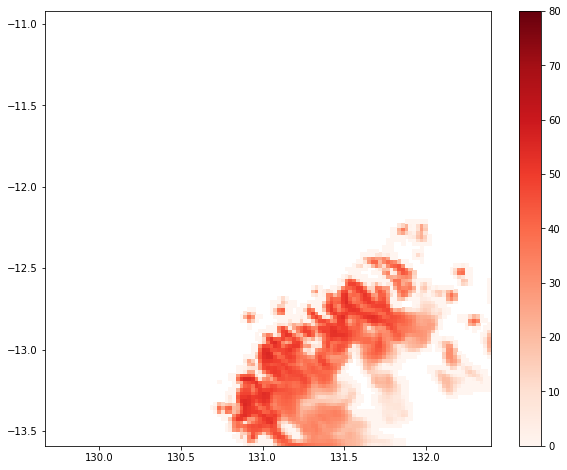

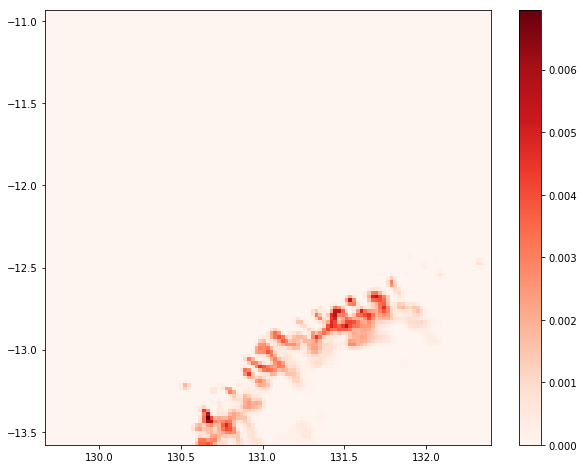

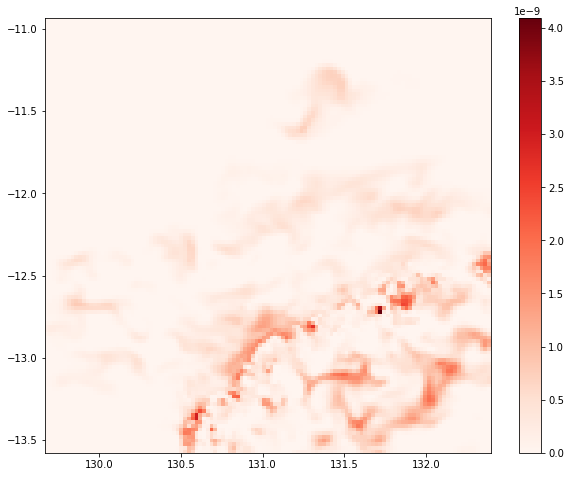

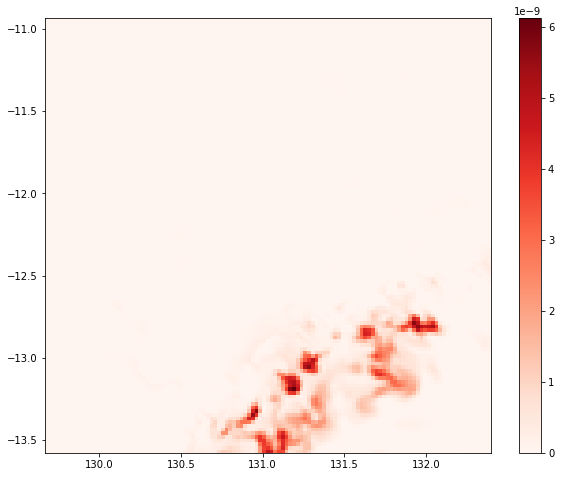

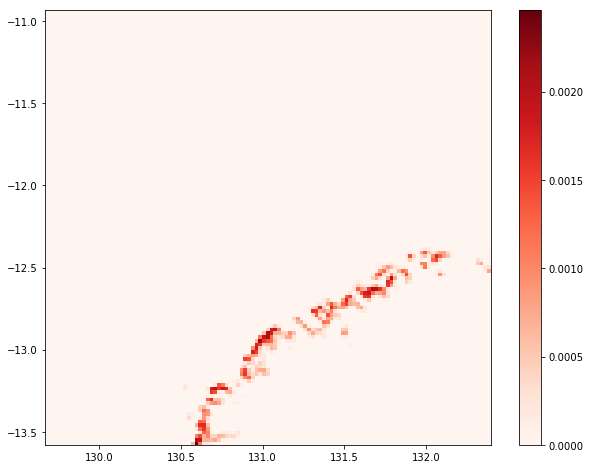

In [10]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ref.x, ref.y, ref.reflectivity.sel(z=3000, method='nearest'), 
               vmin=0, vmax=80, cmap='Reds')
plt.colorbar()
plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.west_east, wrf_water.south_north, 
               wrf_water.QRAIN.sel(bottom_top=3000, method='nearest'), 
               cmap='Reds')
plt.colorbar()
plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.west_east, wrf_water.south_north, 
               wrf_water.QGRAUP.sel(bottom_top=3000, method='nearest'), 
               cmap='Reds')# colors='k')
plt.colorbar()

plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.west_east, wrf_water.south_north, 
               wrf_water.QSNOW.sel(bottom_top=3000, method='nearest'), 
               cmap='Reds')# colors='k')
plt.colorbar()

plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.west_east, wrf_water.south_north, 
               wrf_water.QCLOUD.sel(bottom_top=3000, method='nearest'), 
               cmap='Reds')# colors='k')
plt.colorbar()


NameError: name 'rain_ref' is not defined

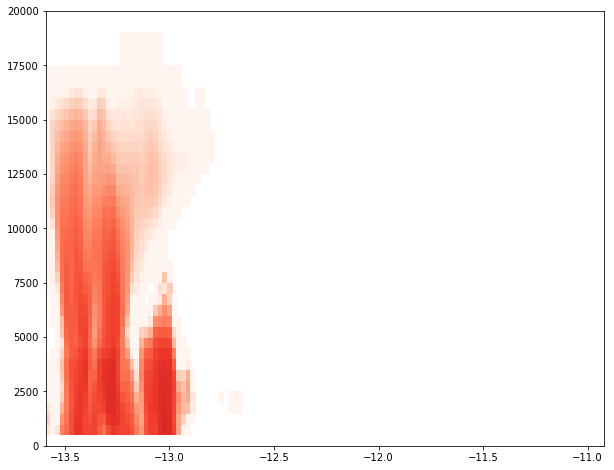

<Figure size 720x576 with 0 Axes>

In [11]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ref.y, ref.z, ref.reflectivity.sel(x=131, method='nearest'), 
               vmin=0, vmax=80, cmap='Reds')
plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.south_north, wrf_water.bottom_top, rain_ref.sel(west_east=131, method='nearest'), cmap='Reds')
plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.south_north, wrf_water.bottom_top, wrf_water.QSNOW.sel(west_east=131, method='nearest'), cmap='Reds')
plt.figure(figsize=(10, 8))
plt.pcolormesh(wrf_water.south_north, wrf_water.bottom_top, (wrf_water.QSNOW+wrf_water.QGRAUP+wrf_water.QRAIN).sel(west_east=131, method='nearest'), cmap='Reds')

# Calculate Reflectivity

In [14]:
rho_air = 1.225
N0r = 8*10**6
N0g = 4*10**6
N0s = 2*10**7
rho_rain = 1000
rho_snow = 100
rho_graup = 400

In [15]:
T = (wrf_water.T + 300)*(100000/(wrf_water.PB+wrf_water.P)) ** (-0.286) - 273.15

In [16]:
rain_ref = 720*(rho_air * wrf_water.QRAIN) ** (7/4) / (N0r ** (3/4) * (np.pi * rho_rain) ** (7/4))
snow_ref = 720*(rho_air * wrf_water.QSNOW) ** (7/4) / (N0s ** (3/4) * (np.pi * rho_snow) ** (7/4)) * (rho_snow / rho_rain) ** 2 * (T < 0) *  0.224 
graup_ref = 720*(rho_air * wrf_water.QGRAUP) ** (7/4) / (N0g ** (3/4) * (np.pi * rho_graup) ** (7/4)) * (rho_graup / rho_rain) ** 2 * (T < 0) * 0.224 

In [17]:
Z = 10 * np.log10(10 ** 18 * (rain_ref+snow_ref+graup_ref))

In [18]:
Z.values[Z<0] = np.nan

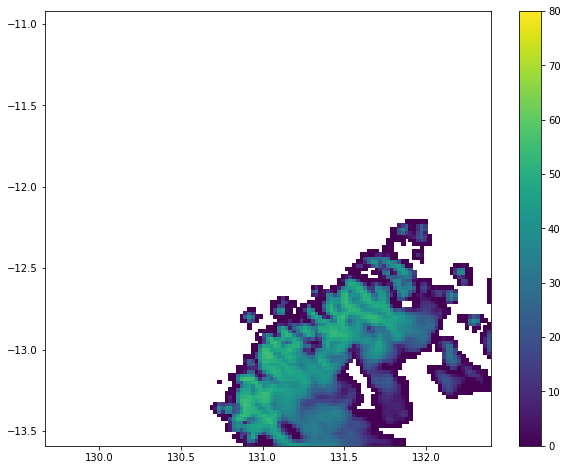

In [19]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ref.x, ref.y, ref.reflectivity.sel(z=3000, method='nearest'), 
               vmin=0, vmax=80)
plt.colorbar()

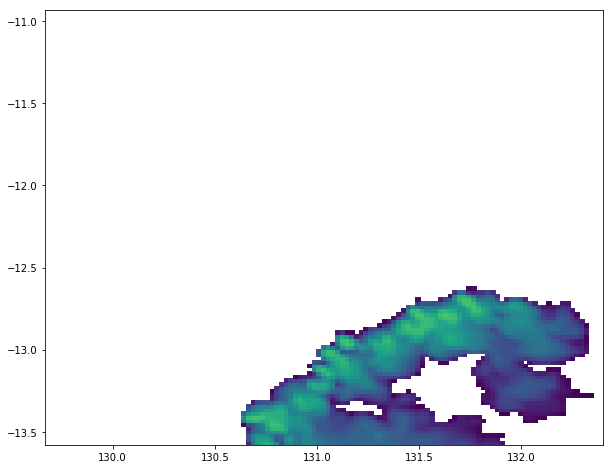

In [31]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(Z.west_east, Z.south_north, Z.sel(bottom_top=8000, method='nearest'), vmin=0, vmax=80)
# plt.colorbar()

In [65]:
from netCDF4 import Dataset
from wrf import getvar, interplevel